In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 
from tqdm import tqdm
from pathlib import Path

import sys
sys.path.append('../src')
from networks_debug import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import *

In [2]:

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = 'cuda'
print(f'Using device {device}')

Using device cuda


In [3]:
batch_size = 512
slope = 10
# network parameters
num_inputs = 6 
num_steps = 40
net_hidden_1 = 180
net_hidden_2 = 400
net_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200
vth_in = 1.0
vth_out = 1.0
vth_recurrent = 1.0
vth_enc_value =  1.0
vth_std =  65 
beta_in = 0.5
beta_recurrent = 0.5
beta_back = 0.6
beta_out = 0.5
encoder_dim = 25
beta_std = 55
lr = 0.002
drop_recurrent =0.15
drop_back = 0.15
drop_out = 0.15
# spiking neuron parameters
beta = 0.8  # neuron decay rate


In [4]:
DATASET_NAME = 'data_watch_subset_0_40.npz'
DATASET_SUBSET = 'custom'
SUBSET_LIST = [0, 2, 6, 8, 9, 14, 17]
PATIENCE = 12
TRAIN_FOLDER_NAME = 'Trained'
NUM_WORKERS = 8
NET_OUTPUT_DIM = 7
NET_INPUT_DIM = 6
NUM_EPOCHS = 200
SEARCH_SPACE_SHUFFLE = 200

In [6]:
trained_folder = TRAIN_FOLDER_NAME
os.makedirs(trained_folder, exist_ok=True)
dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/{DATASET_NAME}', norm=None, class_sublset=DATASET_SUBSET, subset_list=SUBSET_LIST)
train_set = dataset.get_training_set()
val_set = dataset.get_validation_set()


data, label = train_set
print(data.shape)

train_dataset = WisdmDataset(train_set)
val_dataset = WisdmDataset(val_set)

train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=NUM_WORKERS)
val_loader  = DataLoader(dataset= val_dataset, batch_size=int(batch_size), shuffle=True, num_workers=NUM_WORKERS)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device {device}')

grad = surrogate.fast_sigmoid(slope) #use slope for HPO

net_loss = regularization_loss(0.1, 0.03, 40)

net = QuantAhpcNetwork(NET_INPUT_DIM, int(net_hidden_1), int(net_hidden_2), NET_OUTPUT_DIM, grad,
                    vth_in=vth_in, vth_recurrent=vth_recurrent, vth_out=vth_out,
                    beta_in=beta_in, beta_recurrent=beta_recurrent, beta_back=beta_back, beta_out=beta_out,
                    # encoder_dim=int(encoder_dim),
                    # vth_enc_value=vth_enc_value, vth_std=vth_std, beta_std=beta_std,
                    drop_recurrent=drop_recurrent, drop_back=drop_back, drop_out=drop_out,
                    time_dim=2, layer_loss=net_loss).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)

loss_fn = SF.loss.ce_count_loss()

stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler, lam=1.0)

count = 0
for epoch in range(NUM_EPOCHS):
    labels = []
    outputs = []
    # if epoch % 20 == 0:
    #     assistant.reduce_lr()
    if count < PATIENCE:
        count = count+1
        tqdm_dataloader = tqdm(train_loader)
        for _, batch in enumerate(tqdm_dataloader): # training loop
            input, label = batch
            
            output = assistant.train(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Training: {stats.training}')

        tqdm_dataloader = tqdm(val_loader)
        for _, batch in enumerate(tqdm_dataloader): #eval loop
            input, label = batch
            output = assistant.test(input, label)
            tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Validation: {stats.testing}')
        
            if len(outputs) == 0:
                outputs = output.to('cpu').detach()
                labels = label.to('cpu').detach()
            else:
                outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                labels = torch.cat((labels, label.to('cpu').detach()))

        stats.update()

        if stats.testing.best_accuracy:
            count = 0
            _, predictions = outputs.sum(dim=0).max(1)
            gen_confusion_matrix(predictions,labels, f'./{trained_folder}/')
            net.save_to_npz(f'./{trained_folder}/network_best.npz')
            stats.save( f'./{trained_folder}/')
            stats.plot(path=f'./{trained_folder}/')
            del predictions
        del labels
        del outputs
        
        torch.cuda.empty_cache()
    else:
        print('Early stopping')
        break

    

    



(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 7 occurrences of each class:[3127 2855 3102 3047 3150 2973 3213]
num classes eval dataset: 7 occurrences of each class:[1035  935 1122  996 1110 1007 1077]
num classes test dataset: 7 occurrences of each class:[1046  900 1046 1036 1076  982 1054]
(21467, 6, 40)


In [ ]:
stats.save( f'./{trained_folder}/')

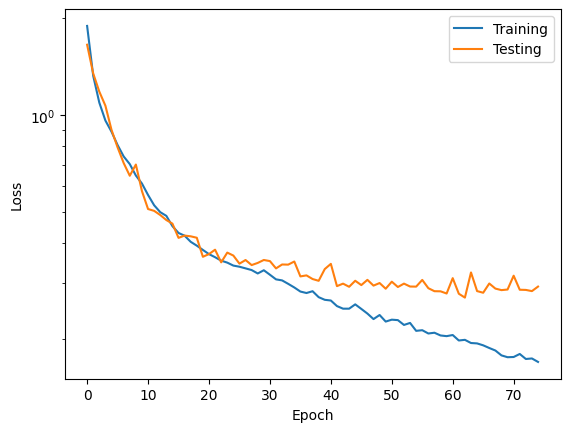

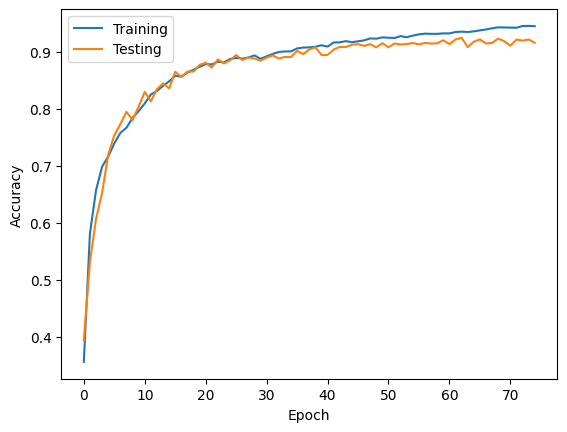

In [ ]:
stats.plot()

In [ ]:
print(type(net))

<class 'networks_debug.QuantAhpcNetwork'>


In [ ]:
# net.from_npz(f'./{trained_folder}/network_best.npz')
net.from_npz(f'./Trained_subset_2_NO_ENCODER/network_best.npz')
net.to(device)

from snntorch.functional import probe

monitor = probe.OutputMonitor(net, instance = snn.Leaky)
monitor.enable()

tqdm_dataloader = tqdm(val_loader)
for _, batch in enumerate(tqdm_dataloader): #eval loop
    input, label = batch
    net.debug_init()
    output = assistant.test(input, label)

    spike, state = net.get_monitor_results()
    #for i in range(0, 10):
    # plt.plot(spike[:,0,:].cpu().numpy())
    # plt.show()
    # print(f'monitor.records={spike.records}')
    # print(f'monitor[0]={spike[0]}')
    print(f'monitor.monitored_layers={spike.monitored_layers}')
    break
        
    tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{NUM_EPOCHS}] Final Validation: {stats.testing}')



  0%|          | 0/15 [00:00<?, ?it/s]

monitor.monitored_layers=['leaky1', 'recurrent', 'recurrent.recurrent.activation', 'leaky2']


In [ ]:
print(f'state_monitor={state.monitored_layers}')

state_monitor=['leaky1', 'recurrent.recurrent.activation', 'leaky2']


In [ ]:
print(f"state_monitor[0]={len(state['leaky1'])}")
print(f"state_monitor[0]={state['leaky1'][0].shape}")


state_monitor[0]=40
state_monitor[0]=torch.Size([512, 180])
